##Requirements

In [ ]:
!pip install tensorflow-compression


In [ ]:
! git clone https://github.com/bckenstler/CLR
! ls 'CLR'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow_compression import GDN
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Add, Subtract, Lambda, Multiply, Softmax, Input, Reshape, Reshape, Softmax
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.applications import VGG19
from CLR.clr_callback import CyclicLR
from skimage.io import imread
from skimage.transform import resize
from matplotlib import pyplot as plt

In [ ]:
!nvidia-smi -L

##Modules

In [ ]:
class DataGenerator(Sequence):
    """Generates data for Keras"""

    def __init__(self, list_IDs, batch_size=32, dim=(256, 256), n_channels=3,
                 n_classes=0, shuffle=True):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size

        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample

            X[i,] = np.asarray(resize(imread(ID), (self.dim[0], self.dim[1], self.n_channels)))
            y = X

        return X, y


def convolutional_block(X, out_ch, downsample, actv2):
    """
    Implementation of the Residual convolutional block
    Skip Connections:
    They mitigate the problem of vanishing gradient by allowing the alternate shortcut path for gradient to flow through
    They allow the model to learn an identity function which ensures that the higher layer will perform at least as good as the lower layer, and not worse


    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    out_ch -- Number of filters
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)

    https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33#43fa
    """

    stride = 2 if downsample else 1

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(out_ch, kernel_size=3, strides=stride, padding='same',
               activation=LeakyReLU(alpha=0.2))(X)

    # Second component of main path
    if actv2 == 2:
        X = Conv2D(out_ch, kernel_size=3, padding='same',
                   activation=GDN(inverse=True))(X)
    if actv2 == 1:
        X = Conv2D(out_ch, kernel_size=3, padding='same',
                   activation=GDN(inverse=False))(X)
    else:
        X = Conv2D(out_ch, kernel_size=3, padding='same')(X)

    ##### SHORTCUT PATH #### (≈2 lines) if downsample handles different channels, replace by identity if not needed
    # if downsample:
    X_shortcut = Conv2D(out_ch, kernel_size=(1, 1), strides=stride, padding='same')(X_shortcut)

    # Final step: Add shortcut value to main path
    X = Add()([X, X_shortcut])

    return X


def NLAM(X, out_ch, downsample):
    """
    Non-Local Attention Module
    Attention modules are used to make CNN learn and focus more on the important information,
    rather than learning non-useful background information. In the case of object detection,
    useful information is the objects or target class crop that we want to classify and localize in an image.
    The attention module consists of a simple 2D-convolutional layer, MLP(in the case of channel attention),
    and sigmoid function at the end to generate a mask of the input feature map.

    """

    # Internal Parameters
    actv2 = 1

    stride = 2 if downsample else 1

    # Save the input value
    X_shortcut = X
    X_main = X

    # Mask Block
    X = convolutional_block(X, out_ch, downsample, actv2)
    X = convolutional_block(X, out_ch, downsample, actv2)
    X = convolutional_block(X, out_ch, downsample, actv2)
    # Conv Layer
    X = Conv2D(out_ch, kernel_size=1, strides=1, padding='same', activation='sigmoid')(X)

    # Main Block
    X_main = convolutional_block(X_main, out_ch, downsample, actv2)
    X_main = convolutional_block(X_main, out_ch, downsample, actv2)
    X_main = convolutional_block(X_main, out_ch, downsample, actv2)

    # Final
    # if downsample:
    X_shortcut = Conv2D(out_ch, kernel_size=(1, 1), strides=stride ** 3, padding='same')(X_shortcut)
    Y = Multiply()([X, X_main])
    Y = Add()([Y, X_shortcut])

    return Y


def UpSample(X, out_ch):
    # Save the input value
    X_shortcut = X

    # Path 1
    X = Conv2D(4 * out_ch, kernel_size=3, padding='same', activation=LeakyReLU(alpha=0.2))(X)
    X = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(X)
    X = Conv2D(out_ch, kernel_size=3, padding='same', activation=GDN(inverse=True))(X)

    # Path 2
    X_shortcut = Conv2D(4 * out_ch, kernel_size=1, padding='same')(X_shortcut)

    X_shortcut = Lambda(lambda x: tf.nn.depth_to_space(x, 2))(X_shortcut)

    # Final step: Add shortcut value to main path
    Y = Add()([X, X_shortcut])

    return Y


def Quantize(X):
    # Mode 0 = Training, 1 = Inference

    X_shape = tf.shape(X, out_type=tf.dtypes.int32)

    return Lambda(lambda x: tf.math.round(x), name='Inference_Quantizer')(X), Add(name='Training_Quantizer')(
        [X, tf.random.uniform(X_shape, minval=-0.5, maxval=0.5, dtype=tf.dtypes.float32)])



def SSIM_MAE_VGG_Loss(y_true, y_pred):
    alpha = 0.4

    mae = tf.reduce_mean(tf.math.abs(y_true - y_pred))
    ssim = 1 - tf.reduce_mean(tf.image.ssim_multiscale(y_pred, y_true, 1.0))
    vgg = vgg_loss(y_true, y_pred)

    return alpha * ssim + (1 - alpha) * mae + vgg 


def PSNR(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0), name='PSNR')


vgg = VGG19(weights="imagenet", include_top=False, input_shape=(None, None, 3))
vgg.outputs = [vgg.get_layer('block5_conv4').output]
vgg_model = tf.keras.models.Model(inputs=vgg.inputs, outputs=vgg.outputs)
vgg_model.trainable = False


def vgg_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs((vgg_model(y_true)[0] - vgg_model(y_pred)[0])), axis=-1)


class MaskConv2D(tf.keras.layers.Layer):
    def __init__(self, input_shape, channels=384, k_size=7):
        super().__init__()
        self.conv = Conv2D(filters=channels, kernel_size=k_size, padding='same', activation=LeakyReLU(alpha=0.2))
        k = k_size
        self.conv.build(input_shape)
        self.channels = channels
        self.k_size = k_size
        mask = np.ones((k, k), dtype=np.float32)
        mask[k // 2, k // 2:] = 0
        mask[k // 2 + 1:, :] = 0
        mask = np.expand_dims(mask, -1)
        mask = np.expand_dims(mask, -1)

        self.conv.weights[0].assign(self.conv.weights[0] * mask)

    def get_config(self):
        config = {'input_shape': self.input_shape,
                  'channels': self.channels,
                  'k_size': self.k_size}
        return config

    def call(self, inputs):
        return self.conv(inputs)


def Parameter_Estimate(X, gmm_K):

    Y = MaskConv2D(input_shape=X.shape, channels=384, k_size=5)(X)
    Y = Conv2D(640, kernel_size=1, padding='same', activation=LeakyReLU(alpha=0.2))(Y)
    Y = Conv2D(640, kernel_size=1, padding='same', activation=LeakyReLU(alpha=0.2))(Y)
    Y = Conv2D(3 * gmm_K * X.shape[-1], kernel_size=1, padding='same', name='GMM')(Y)

    return Y


def bitcost(P, Y_hat):

    gmm_K = 3
    batch, dim1, dim2, dim3 =tf.shape(Y_hat)

    P = tf.reshape(P,(-1,dim1, dim2, gmm_K, 3 * dim3))


    mu = tf.slice(P,[0,0,0,0,0],[batch,dim1,dim2,gmm_K,dim3])
    std_dev = tf.slice(P,[0,0,0,0,dim3],[batch,dim1,dim2,gmm_K,dim3])
    weights = tf.slice(P,[0,0,0,0,2 * dim3],[batch,dim1,dim2,gmm_K,dim3])
    weights = Softmax(axis=3)(weights)
    total_diff = 1e-6

    for k in range(gmm_K):
        #slicing
        weight_k = weights[:, :, :, k, :]
        mu_k = mu[:, :, :, k, :]

        std_dev_k = Lambda(lambda x:tf.math.abs(x))(std_dev[:, :, :, k, :])

        std_dev_k = std_dev_k+1e-6
        std_dev_rec = Lambda(lambda x:tf.math.reciprocal(x))(std_dev_k)
        #constants

        denom = Lambda(lambda x:tf.math.divide(x,tf.math.sqrt(2.0)))(std_dev_rec)

        Y_hat_ = Subtract()([Y_hat,mu_k])
        #upper limit
        upper_y = Y_hat_+0.5
        upper_y = Multiply()([upper_y,denom])
        erf = Lambda(lambda x:tf.math.erf(x))(upper_y)
        upper_limit = 1+erf
        upper_limit = upper_limit*0.5


        #upper limit
        lower_y = Y_hat_-0.5
        lower_y = Multiply()([lower_y,denom])
        erf = Lambda(lambda x:tf.math.erf(x))(lower_y)
        lower_limit = 1+erf
        lower_limit = lower_limit*0.5


        diff = Subtract()([upper_limit,lower_limit])
        diff = Multiply()([diff,weight_k])
        total_diff = total_diff+diff

        

    return -(tf.math.log(total_diff)) / (tf.math.log(2.0) * 256 * tf.cast(dim1 * dim2,dtype=tf.float32))


def Bit_Loss(y_true, y_pred):
    sum = tf.reduce_sum(y_pred)
    target = 0
    return tf.math.abs(sum-target)

80142336/80134624 [==============================] - 1s 0us/step


##Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/model')

Mounted at /content/model


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip

In [ ]:
!mkdir /content/coco_dataset
!unzip -q /content/train2017.zip -d /content/coco_dataset 
!unzip -q /content/val2017.zip -d /content/coco_dataset 

In [ ]:
import os
import random 
from glob import glob
from pathlib import Path

DATASET_DIR = os.path.join("/content/coco_dataset", "")
TRAIN_DIR = os.path.join(DATASET_DIR, "train2017")
VAL_DIR = os.path.join(DATASET_DIR, "val2017")
#TEST_DIR = os.path.join(DATASET_DIR, "test")

training_data = [y for x in os.walk(TRAIN_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
validation_data = [y for x in os.walk(VAL_DIR) for y in glob(os.path.join(x[0], '*jpg'))]
#test_data = [y for x in os.walk(TEST_DIR) for y in glob(os.path.join(x[0], '*JPEG'))]
print(len(validation_data))
training_data[:10]

5000


['/content/coco_dataset/train2017/000000015693.jpg',
 '/content/coco_dataset/train2017/000000178218.jpg',
 '/content/coco_dataset/train2017/000000397893.jpg',
 '/content/coco_dataset/train2017/000000291941.jpg',
 '/content/coco_dataset/train2017/000000388311.jpg',
 '/content/coco_dataset/train2017/000000501026.jpg',
 '/content/coco_dataset/train2017/000000207010.jpg',
 '/content/coco_dataset/train2017/000000146988.jpg',
 '/content/coco_dataset/train2017/000000379517.jpg',
 '/content/coco_dataset/train2017/000000243557.jpg']

In [ ]:
BATCH_SIZE = 2
HEIGHT = 512
WIDTH = 512
params = {'dim': (HEIGHT, WIDTH),
          'batch_size': BATCH_SIZE,
          'shuffle': False}
training_generator = DataGenerator(training_data, **params)
validation_generator = DataGenerator(validation_data, **params)
#test_generator = DataGenerator(test_data, **params)

##Encoder

In [ ]:
ch = 192
out_ch = 32
img_input = Input(shape=(None, None, 3),name='Image')

ResBlock_1 = convolutional_block(img_input, ch, 1, 1)
ResBlock_2 = convolutional_block(ResBlock_1, ch, 0, 1)
ResBlock_3 = convolutional_block(ResBlock_2, ch, 1, 1)
NLAM_1 = NLAM(ResBlock_3, ch, 0)
ResBlock_4 = convolutional_block(NLAM_1, ch, 0, 1)
ResBlock_5 = convolutional_block(ResBlock_4, ch, 1, 1)
ResBlock_6 = convolutional_block(ResBlock_5, ch, 0, 1)
NLAM_2 = NLAM(ResBlock_6, ch, 0)
final_conv2d = Conv2D(out_ch, kernel_size=3, strides=2, padding='same',
                      activation=LeakyReLU(alpha=0.2))(NLAM_2)

y_hard , y_soft = Quantize(final_conv2d)
    
Encoder = Model(inputs=img_input,outputs=[y_hard , y_soft],name='Encoder')


##َEntropy Model

In [ ]:
latent_code = Input(shape=(None, None, out_ch),name='Latent_Code')
params = Parameter_Estimate(latent_code,3)
bits_per_pixel = bitcost(params,latent_code)
Entropy_Model=Model(inputs=latent_code,outputs=[bits_per_pixel,params],name='Entropy_Model')

##Decoder

In [ ]:
decoder_input = Input(shape=(None, None, out_ch),name='Decoder_Input')
conv2d_1 = Conv2D(ch, kernel_size=3, padding='same',
                      activation=LeakyReLU(alpha=0.2))(decoder_input)
NLAM_1 = NLAM(conv2d_1, ch, 0)
ResBlock_1 = convolutional_block(NLAM_1, ch, 0, 2)
UpResBlock_1 = UpSample(ResBlock_1, ch)
ResBlock_2 = convolutional_block(UpResBlock_1, ch, 0, 2)
UpResBlock_2 = UpSample(ResBlock_2, ch)
NLAM_2 = NLAM(UpResBlock_2, ch, 0)
ResBlock_3 = convolutional_block(NLAM_2, ch, 0, 2)
UpResBlock_3 = UpSample(ResBlock_3, ch)
ResBlock_4 = convolutional_block(UpResBlock_3, ch, 0, 2)
conv2d_2 = Conv2D(12, kernel_size=3, padding='same')(ResBlock_4)

UpResBlock_4 = UpSample(conv2d_2, 3)

Decoder = Model(inputs=decoder_input, outputs = UpResBlock_4,name='Decoder')

##End to End Autoencoder

In [ ]:
autoencoder_input = Input(shape=(None, None, 3),name='Image')
encoder_output = Encoder(autoencoder_input)[1]
bpp = Entropy_Model(encoder_output)[0]

decoder_output = Decoder(encoder_output)
    
autoencoder = Model(inputs=autoencoder_input,
                    outputs=[bpp,decoder_output],
                    name='End_to_End')


autoencoder.build((None, None, 3))

opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

autoencoder.compile(optimizer=opt,
                    loss=[Bit_Loss,SSIM_MAE_VGG_Loss],
                    loss_weights=[0.1,0.9],
                    metrics={'Decoder':PSNR})


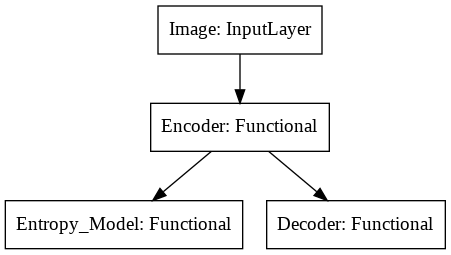

In [ ]:
 tf.keras.utils.plot_model(autoencoder)

#Callbacks and Training

In [ ]:
#autoencoder.load_weights('/content/model/MyDrive/cv_models/SSIM_MAE_VGG_COCO_model.h5')
clr = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=781, gamma=0.99994)
chk_point = tf.keras.callbacks.ModelCheckpoint(filepath='/content/model/MyDrive/cv_models/SSIM_MAE_VGG_ADV_COCO_model.{epoch:02d}.h5')
ton = tf.keras.callbacks.TerminateOnNaN()

NUM_EPOCHS = 10

history = autoencoder.fit(training_generator,
                      callbacks = [clr,ton,chk_point],
                      validation_data=validation_generator,
                      epochs=NUM_EPOCHS)
autoencoder.save('/content/model/MyDrive/cv_models/SSIM_MAE_VGG_COCO_ADV_model.h5',save_format="h5")